# Compute CMIP6 climate indicators with xclim and dask

In [1]:
import xarray as xr

In [2]:
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster

In [3]:
client = Client(n_workers=6)

In [5]:
client

Client Scheduler: tcp://127.0.0.1:37354 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 6 Cores: 48 Memory: 248.44 GiB


In [20]:
# client.shutdown()

In [6]:
import glob

url_hist = "/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/day/tas/gn/v20190710/tas_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_*"
url_scen = "/pool/data/CMIP6/data/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp126/r1i1p1f1/day/tas/gn/v20190710/tas_day_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_20*"
# url = "/pool/data/CMIP6/data/CMIP/MIROC/MIROC6/historical/r1i1p1f1/day/tas/gn/v20191016/tas_day_MIROC6_historical_r1i1p1f1_gn_*"
filenames = glob.glob(url_hist) + glob.glob(url_scen)
filenames.sort()
filenames

['/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/day/tas/gn/v20190710/tas_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18500101-18691231.nc',
 '/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/day/tas/gn/v20190710/tas_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18700101-18891231.nc',
 '/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/day/tas/gn/v20190710/tas_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_18900101-19091231.nc',
 '/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/day/tas/gn/v20190710/tas_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_19100101-19291231.nc',
 '/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/day/tas/gn/v20190710/tas_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_19300101-19491231.nc',
 '/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/day/tas/gn/v20190710/tas_day_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_19500101-19691231.nc',
 '/pool/data/CMIP6/data/CMIP/MPI-M/MPI-ESM1-2-LR/his

In [7]:
client

Client Scheduler: tcp://127.0.0.1:37354 Dashboard: /user/g300046/advanced//proxy/8787/status,Cluster Workers: 6 Cores: 48 Memory: 248.44 GiB


In [8]:
ds = xr.open_mfdataset(filenames, parallel=True, chunks="auto")

In [9]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, time: 91676)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T12:00:00
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(7305, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(7305, 96, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(7305, 192, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(1461, 96, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/5b1b3985-5715-4dcc-a13e-c08d1fc3d400

In [42]:
DEFAULT_BASE_PERIOD = slice("1971-01-01", "2000-12-31")
from xclim.core.calendar import percentile_doy
from xclim.indices import tg10p

tas = ds.tas
t10 = percentile_doy(tas.sel(time=DEFAULT_BASE_PERIOD), per=10).sel(percentiles=10)

/work/ch0636/g300046/conda_envs/cmip6-xclim/lib/python3.9/site-packages/xclim/core/calendar.py:478: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  p = xr.apply_ufunc(


In [26]:
import dask

with dask.config.set(**{"array.slicing.split_large_chunks": False}):
    cold_days = tg10p(ds.tas.sel(time=slice("1950", "2100")), t10)

In [27]:
cold_days_ = cold_days.persist()
progress(cold_days_)

VBox()

In [28]:
cold_days__ = cold_days_.compute()

In [29]:
cold_days__

<xarray.DataArray 'tas' (time: 151, lat: 96, lon: 192)>
array([[[41, 39, 40, ..., 43, 44, 43],
        [11, 11,  8, ..., 12, 12, 11],
        [ 6,  7,  6, ...,  6,  5,  5],
        ...,
        [66, 67, 70, ..., 70, 66, 64],
        [79, 77, 82, ..., 79, 80, 80],
        [85, 89, 87, ..., 81, 84, 84]],

       [[25, 26, 25, ..., 23, 24, 23],
        [50, 50, 53, ..., 47, 48, 50],
        [57, 59, 62, ..., 49, 55, 56],
        ...,
        [37, 37, 38, ..., 33, 32, 39],
        [37, 39, 37, ..., 41, 38, 40],
        [30, 30, 32, ..., 33, 32, 31]],

       [[53, 55, 56, ..., 52, 53, 53],
        [29, 27, 27, ..., 28, 29, 29],
        [20, 20, 18, ..., 21, 23, 20],
        ...,
...
        ...,
        [15, 15, 16, ..., 18, 16, 15],
        [18, 18, 16, ..., 18, 17, 18],
        [12, 12, 12, ..., 11, 11, 11]],

       [[25, 25, 24, ..., 24, 25, 26],
        [11, 10, 10, ..., 15, 16, 12],
        [17, 13, 15, ..., 17, 17, 17],
        ...,
        [ 7,  7,  7, ...,  4,  5,  6],
        [ 7,  6,  6, ...,  7,  7,  7],
        [ 5,  5,  5, ...,  6,  5,  5]],

       [[25, 23, 23, ..., 26, 25, 25],
        [26, 26, 28, ..., 27, 27, 26],
        [29, 26, 28, ..., 28, 28, 28],
        ...,
        [ 7,  7,  6, ...,  7,  7,  7],
        [11, 10, 10, ..., 12, 12, 12],
        [13, 13, 13, ..., 13, 13, 13]]])
Coordinates:
  * time         (time) datetime64[ns] 1950-01-01 1951-01-01 ... 2100-01-01
  * lat          (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon          (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height       float64 2.0
    percentiles  int64 10
Attributes:
    units:    d

In [39]:
import numpy as np

weights = np.cos(np.deg2rad(cold_days__.lat))
weights.name = "weights"
cold_days_mean = cold_days__.weighted(weights).mean(dim=("lat", "lon")).compute()

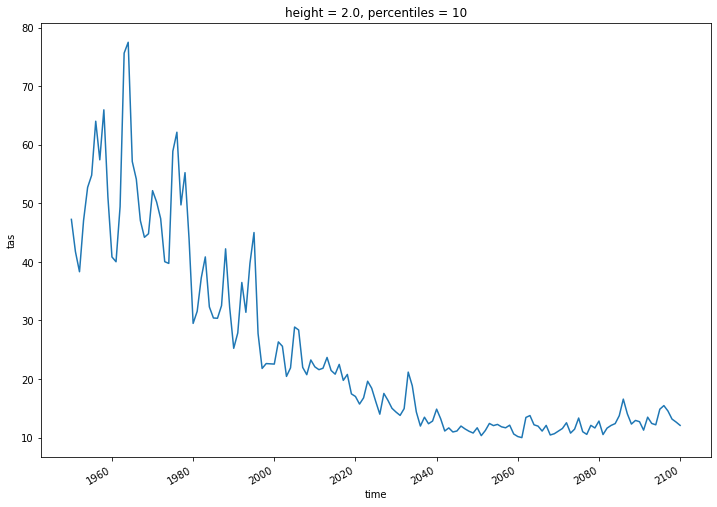

In [46]:
import seaborn
from hvplot import xarray

cold_days_mean.plot(figsize=(12, 8))